In [19]:
import torch
import torchvision


from collections import defaultdict
from functools import reduce
from itertools import product, combinations
from time import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [ ]:
#train_dataset = torchvision.datasets.CelebA(root='/content/drive/MyDrive/', split='train', download=True)
#test_dataset = torchvision.datasets.CelebA(root='/content/drive/MyDrive/', split='test', download=True)
#validation_dataset = torchvision.datasets.CelebA(root='/content/drive/MyDrive/', split='valid', download=True)

RuntimeError: ignored

In [2]:
from torchvision import transforms
path = '/content/drive/MyDrive/celebrities'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)

In [3]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )

In [22]:
seed = 42
alpha = .01


def reset_data_and_parameters(n_units=3, n_obs=100, p=[.8, .1, .5]):
    """
    Generate training data, weights, biases, and a list of all data configurations
    in our model's support.
    
    In addition, generate a list of tuples of the indices of adjacent nodes, which
    we'll use to update parameters without duplication. 
    
    For example, with `n_units=3`, we generate a matrix of weights with shape (3, 3); 
    however, there are only 3 distinct weights in this matrix that we'll actually 
    want to update: those connecting Node 0 --> Node 1, Node 1 --> Node 2, and 
    Node 0 --> Node 2. This function returns a list containing these tuples 
    named `var_combinations.
    
    :param n_units: the dimensionality of our data `d`
    :param n_obs: the number of observations in our training set
    :param p: a vector of the probabilities of observing a 1 in each index
        of the training data. The length of this vector must equal `n_units`
        
    :return: weights, biases, var_combinations, all_configs, data
    """
    np.random.seed(seed)
    
    # initialize data
    data = np.random.binomial(n=1, p=p, size=(100, n_units))
    
    # initialize parameters
    biases = np.random.randn(n_units)
    weights = np.random.randn(n_units, n_units)
    
    # a few other pieces we'll need
    var_combinations = list(combinations(range(n_units), 2))
    all_configs = list(product([0, 1], repeat=n_units))
    
    return weights, biases, var_combinations, all_configs, data


class Model:
    
    def __init__(self, weights, biases, var_combinations, all_configs):
        self.weights = weights
        self.biases = biases
        self.var_combinations = var_combinations
        self.all_configs = all_configs
        self.n_units = len(self.biases)
        
    @staticmethod
    def _inv_logit(z):
        return 1 / (1 + np.exp(-z))
        
    def _unnormalized_likelihood(self, x):
        return np.exp(self._H(x))
        
    def _H(self, x):
        h = 0
        for i, j in self.var_combinations:
            h += self.weights[i, j] * x[i] * x[j]
        h += self.biases @ x
        return h
    
    def likelihood(self, x, log=False):
        """
        :param x: a vector of shape (n_units,) or (n, n_units),
            where the latter is a matrix of multiple data points
            for which to compute the joint likelihood.
        """
        x = np.array(x)
        if not self.n_units in x.shape and len(x.shape) in (1, 2):
            raise('Please pass 1 or more points of `n_units` dimensions')
           
        # compute unnormalized likelihoods
        multiple_samples = len(x.shape) == 2
        if multiple_samples:
            likelihood = [self._unnormalized_likelihood(point) for point in x]
        else:
            likelihood = [self._unnormalized_likelihood(x)]
        
        # compute partition function
        Z = sum([self._unnormalized_likelihood(config) for config in self.all_configs])
        
        if log:
            return sum([np.log(lik) - np.log(Z) for lik in likelihood])
        else:
            return reduce(np.multiply, [lik / Z for lik in likelihood])
        
    def sample(self, n_samples=100, init_sample=None, burn_in=25, every_n=10, seed=seed) -> np.array:

        np.random.seed(seed)

        if burn_in > n_samples:
            raise("Can't burn in for more samples than there are in the chain")

        init_sample = init_sample or [0 for _ in self.biases]
        samples = [init_sample]

        def _gibbs_step(sample, i):
            z = sum([self.weights[i, j] * sample[j] for j in range(len(sample)) if j != i]) + self.biases[i]
            p = self._inv_logit(z)
            return np.random.binomial(n=1, p=p)

        for _ in range(n_samples):
            sample = list(samples[-1])  # make copy
            for i, _ in enumerate(sample):
                sample[i] = _gibbs_step(sample=sample, i=i)
            samples.append( sample )

        return np.array([sample for i, sample in enumerate(samples[burn_in:]) if i % every_n == 0])
    
    def conditional_likelihood(x, cond: dict):
        joint = np.array(x)
        for index, val in cond.items():
            if isinstance(joint[index], int):
                raise
            joint[index] = val

        evidence = [cond.get(i, ...) for i in range(len(x))]

        return self._unnormalized_likelihood(joint) / self.marginal_likelihood(evidence)
    
    def marginal_likelihood(self, x):
        """
        To marginalize, put ellipses (...) in the elements over 
        which you wish to marginalize.
        """
        unnormalized_lik = 0
        for config in product(*[[0, 1] if el == ... else [el] for el in x]):
            config = np.array(config)
            unnormalized_lik += np.exp(self._H(config))
        return unnormalized_lik


def update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=alpha, **kwargs):
    model = Model(weights, biases, var_combinations, all_configs)
    model_distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = sum([config[i] * config[j] * likelihood for config, likelihood in model_distribution])

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = sum([config[i] * likelihood for config, likelihood in model_distribution])
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

In [23]:
weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=3, p=[.8, .1, .5])


for i in range(100):
    weights, biases = update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=1)
    
    lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
    if i % 10 == 0:
        print(f'Epoch: {i:2} | Likelihood: {lik}')

Epoch:  0 | Likelihood: -209.63758306786653
Epoch: 10 | Likelihood: -162.04280784271083
Epoch: 20 | Likelihood: -160.49961381649558
Epoch: 30 | Likelihood: -159.79539070373576
Epoch: 40 | Likelihood: -159.2853717231018
Epoch: 50 | Likelihood: -158.90186293631422
Epoch: 60 | Likelihood: -158.6084020645482
Epoch: 70 | Likelihood: -158.38094343579158
Epoch: 80 | Likelihood: -158.20287017780586
Epoch: 90 | Likelihood: -158.06232196551667


In [8]:
def plot_n_samples(n_samples, weights, biases):
    """
    NB: We add some jitter to the points so as to better visualize density in a given corner of the model.
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    samples = Model(weights, biases, var_combinations, all_configs).sample(n_samples)
    x, y, z = zip(*np.array(samples))

    x += np.random.randn(len(x)) * .05
    y += np.random.randn(len(y)) * .05
    z += np.random.randn(len(z)) * .05

    ax.scatter(x, y, z)
    ax.set_xlabel('Node 0')
    ax.set_ylabel('Node 1')
    ax.set_zlabel('Node 2')

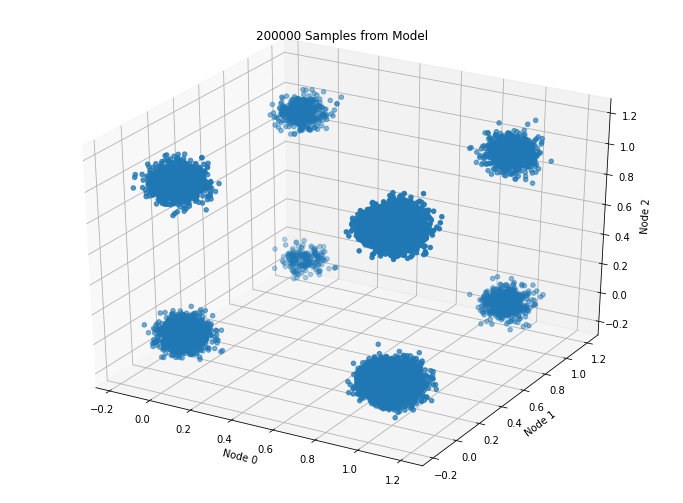

In [9]:
n_samples = 200000

plot_n_samples(n_samples, weights, biases)
_ = plt.title(f'{n_samples} Samples from Model')

In [ ]:
#import torch
#def E(X, Y):
#  return torch.nn.functional.relu(X * Y)
#
#def gibbs(x,y, Y, beta):
#  return torch.exp(-beta * E(x, Y)) / torch.trapz(torch.exp(-beta * E(x, y)))
#
#x = torch.tensor([1., 2., 3., 4., 5.])
#y = torch.tensor([6., 7., 8., 9., 10.])
#Y = torch.tensor([11., 12., 13., 14., 15.])
#beta = 1
#res = gibbs(x, y, Y, beta)
#res, max(res)

(tensor([1.3467e-02, 3.0440e-08, 9.3115e-15, 3.8549e-22, 2.1598e-30]),
 tensor(0.0135))

In [24]:
model = Model(weights, biases, var_combinations, all_configs)

distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]
assert sum([likelihood for config, likelihood in distribution]) == 1

for config, likelihood in distribution:
    print(f'{list(config)}: {likelihood:.4}')

[0, 0, 0]: 0.07327
[0, 0, 1]: 0.09227
[0, 1, 0]: 0.01366
[0, 1, 1]: 0.01938
[1, 0, 0]: 0.3351
[1, 0, 1]: 0.3622
[1, 1, 0]: 0.04693
[1, 1, 1]: 0.05715


In [25]:
empirical_dist = defaultdict(int)
samples = model.sample(n_samples=1000)
n_samples = len(samples)

for sample in samples:
    empirical_dist[tuple(sample)] += 1 / n_samples
assert np.round(sum(empirical_dist.values()), 8) == 1

for config, likelihood in distribution:
    empirical_probability = empirical_dist[tuple(config)]
    print(f'{list(config)}: {likelihood:.4} (true), {empirical_probability:.4} (empirical)')

[0, 0, 0]: 0.07327 (true), 0.05102 (empirical)
[0, 0, 1]: 0.09227 (true), 0.09184 (empirical)
[0, 1, 0]: 0.01366 (true), 0.0102 (empirical)
[0, 1, 1]: 0.01938 (true), 0.02041 (empirical)
[1, 0, 0]: 0.3351 (true), 0.3673 (empirical)
[1, 0, 1]: 0.3622 (true), 0.398 (empirical)
[1, 1, 0]: 0.04693 (true), 0.03061 (empirical)
[1, 1, 1]: 0.05715 (true), 0.03061 (empirical)


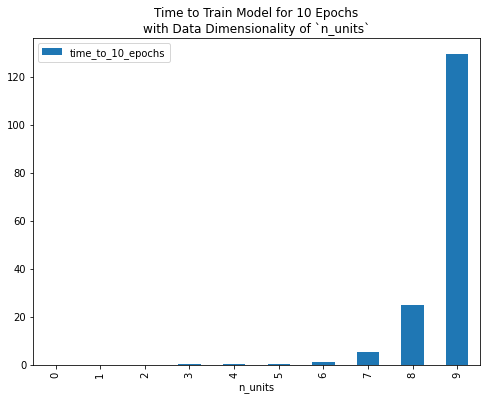

In [26]:
results = []

for n_units in range(10):
    p = np.random.uniform(size=n_units)
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units, p=p)
    start = time()
    for i in range(10):
        weights, biases = update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=1)
    elapsed = time() - start
    
    results.append( {'n_units': n_units, 'time_to_10_epochs': elapsed})
    
    
results_df = pd.DataFrame(results)
title='Time to Train Model for 10 Epochs\nwith Data Dimensionality of `n_units`'
results_df.plot(x='n_units', kind='bar', figsize=(8, 6), title=title)

In [28]:
def update_parameters_with_gibbs_sampling(weights, biases, var_combinations, all_configs, data,
                                          seed=42, n_samples=1000, alpha=alpha, **kwargs):
    model_samples = Model(weights, biases, var_combinations, all_configs).sample(n_samples=n_samples, seed=seed)

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = (model_samples[:, i] * model_samples[:, j]).mean()

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = model_samples[:, i].mean()
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

In [29]:
def train_model_for_n_epochs(optim_algo, n_units, p, run_num, epochs=100, alpha=alpha, verbose=True, n_samples=1000):
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units, p=p)

    timestamps, updates = [], []
    for i in range(epochs):
        timestamps.append(time())
        
        weights, biases = optim_algo(
            weights=weights, 
            biases=biases, 
            var_combinations=var_combinations, 
            all_configs=all_configs, 
            data=data, 
            alpha=alpha,
            seed=run_num,
            n_samples=n_samples
        )
        
        elapsed = timestamps[-1] - timestamps[0]

        lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
        algo_name = optim_algo.__name__.split('update_parameters_with_')[-1]
        if i % 10 == 0 and verbose:
            print(f'Epoch: {i} | Likelihood: {lik}')

        updates.append( {'likelihood': lik, 'algo': algo_name, 'step': i, 'time': elapsed, 'run_num': run_num})
        
    return pd.DataFrame(updates)

In [30]:
all_updates = []
alpha = .1
min_units, max_units = 3, 7

for n_units in range(min_units, max_units):
    
    np.random.seed(n_units)
    p = np.random.uniform(size=n_units)
    n_epochs = 100
    
    if n_units % 5 == 0:
        alpha /= 10

    for run in range(5):
        updates = train_model_for_n_epochs(
            update_parameters_with_gibbs_sampling, 
            n_units=n_units, 
            epochs=100,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))


    for run in range(1):
        updates = train_model_for_n_epochs(
            update_parameters_with_true_negative_phase, 
            n_units=n_units, 
            epochs=100,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))

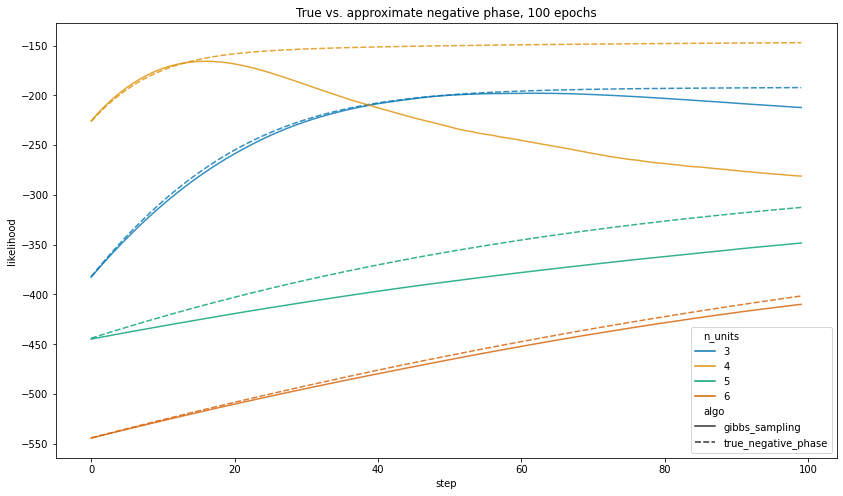

In [31]:
df = pd.concat(all_updates)

plt.figure(figsize=(14, 8))
plt.title('True vs. approximate negative phase, 100 epochs')
sns.lineplot(x="step", y="likelihood", hue="n_units", style="algo", 
                legend="full", data=df, ci=None, alpha=.8, palette=sns.color_palette("colorblind", max_units - min_units))

In [32]:
def train_model_for_n_seconds(optim_algo, n_units, p, run_num, n_seconds=10, alpha=alpha, verbose=True, n_samples=1000):
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units, p=p)

    elapsed = 0
    step = 0
    timestamps, updates = [], []
    
    while elapsed < n_seconds:
        timestamps.append(time())
        
        weights, biases = optim_algo(
            weights=weights, 
            biases=biases, 
            var_combinations=var_combinations, 
            all_configs=all_configs, 
            data=data, 
            alpha=alpha,
            seed=run_num,
            n_samples=n_samples
        )
        
        elapsed = timestamps[-1] - timestamps[0]
        
        lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
        algo_name = optim_algo.__name__.split('update_parameters_with_')[-1]
        if len(timestamps) > 1 and int(timestamps[-1]) - int(timestamps[-2]) > 0 and verbose:
            print(f'Elapsed: {elapsed:.2}s | Likelihood: {lik}')

        updates.append( {'likelihood': lik, 'algo': algo_name, 'step': step, 'time': elapsed, 'run_num': run_num})
        
        step += 1
        
    return pd.DataFrame(updates)

In [33]:
all_updates = []
n_seconds = 1
alpha = .1
min_units, max_units = 3, 10

for n_units in range(min_units, max_units):
    
    np.random.seed(n_units)
    p = np.random.uniform(size=n_units)
    n_epochs = 100
    
    if n_units % 5 == 0:
        alpha /= 10

    for run in range(5):
        updates = train_model_for_n_seconds(
            update_parameters_with_gibbs_sampling, 
            n_units=n_units, 
            n_seconds=n_seconds,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))


    for run in range(1):
        updates = train_model_for_n_seconds(
            update_parameters_with_true_negative_phase, 
            n_units=n_units, 
            n_seconds=n_seconds,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))

Text(0, 0.5, 'Log # of epochs')

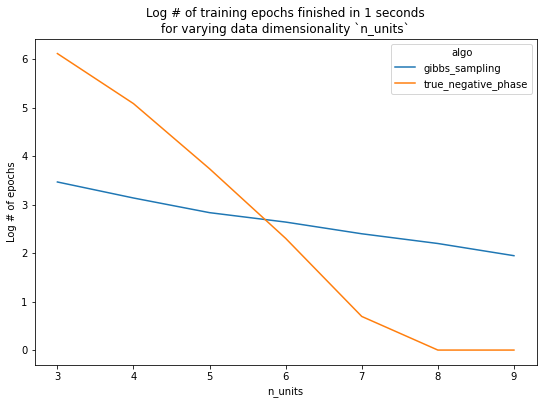

In [34]:
df = pd.concat(all_updates)
n_steps_df = df.groupby(['algo', 'n_units'])['step'].max().map(np.log).reset_index()

plt.figure(figsize=(9, 6))
plt.title('Log # of training epochs finished in 1 seconds\nfor varying data dimensionality `n_units`')
sns.lineplot(x='n_units', y='step', hue='algo', data=n_steps_df)
plt.ylabel('Log # of epochs')

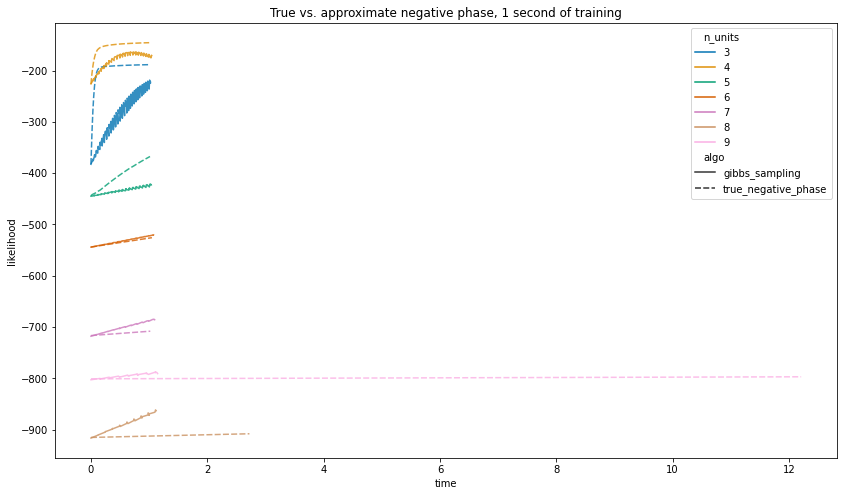

In [35]:
plt.figure(figsize=(14, 8))
plt.title('True vs. approximate negative phase, 1 second of training')
sns.lineplot(x="time", y="likelihood", hue="n_units", style="algo", 
             legend="full", data=df, ci=None, alpha=.8, 
             palette=sns.color_palette("colorblind", max_units - min_units))